In [ ]:
# !pip install datasets


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

from tqdm import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

##Model Declaration

###Attention

In [ ]:
class Attention(nn.Module):
  def __init__(self,embed_dim,head_dim,dropout_rate):
    super(Attention,self).__init__()

    self.query=nn.Linear(embed_dim,head_dim)
    self.key=nn.Linear(embed_dim,head_dim)
    self.value=nn.Linear(embed_dim,head_dim)
    self.dropout=nn.Dropout(dropout_rate)


  def forward(self,query,key,value,mask=None):
    d_k=query.size(-1)

    q=self.query(query)
    k=self.key(key)
    v=self.value(value)

    scores=q @ k.transpose(1,2) /math.sqrt(d_k)
    if mask is not None:
      # mask = mask.unsqueeze(1)
      scores = scores.masked_fill(mask == 0, float('-inf'))

    weights=F.softmax(scores,dim=-1)
    weights=self.dropout(weights)
    out=weights @ v
    return out


In [ ]:
# # Define query, key, and value
# query = torch.rand(2, 4, 16)  # batch_size=2, seq_len=4, embed_dim=16
# key = torch.rand(2, 4, 16)
# value = torch.rand(2, 4, 16)

# # Define a mask where the last element in each sequence is masked (set to 0)
# mask = torch.ones(2, 4, 4)  # mask for batch_size=2, seq_len=4
# mask[:, -1, -1] = 0  # Mask the last element

# # Create Attention instance
# attention = Attention(embed_dim=16, head_dim=8, dropout_rate=0.1)

# # Run the attention with the mask
# output_with_mask = attention(query, key, value, mask=mask)
# output_without_mask = attention(query, key, value)

# # Check that outputs with and without mask are different
# assert not torch.equal(output_with_mask, output_without_mask), "Mask not applied correctly!"
# print("Basic Mask Test Passed!")

###Multihead attention

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self,embed_dim,head_size,dropout_rate):
    super(MultiheadAttention,self).__init__()

    # Validate that embed_dim is divisible by head_size
    assert embed_dim % head_size == 0, "embed_dim must be divisible by head_size"

    self.head_dim=embed_dim//head_size
    self.embed_dim=embed_dim
    self.head_size=head_size

    self.attn_heads=nn.ModuleList([Attention(embed_dim,self.head_dim,dropout_rate) for _ in range(head_size)])
    self.out_layer=nn.Linear(self.head_dim*head_size,embed_dim)
    self.dropout=nn.Dropout(dropout_rate)


  def forward(self,query,key,value,mask=None):

    out=torch.cat([h(query,key,value,mask) for h in self.attn_heads],dim=-1)
    out=self.dropout(self.out_layer(out))
    return out

In [ ]:

# # Define query, key, and value tensors
# query = torch.rand(2, 4, 16)  # batch_size=2, seq_len=4, embed_dim=16
# key = torch.rand(2, 4, 16)
# value = torch.rand(2, 4, 16)

# # Define a mask where the last element in each sequence is masked (set to 0)
# mask = torch.ones(2, 4, 4)  # mask for batch_size=2, seq_len=4
# mask[:, -1, -1] = 0  # Mask the last element

# # Create MultiheadAttention instance
# attention = MultiheadAttention(embed_dim=16, head_size=4, dropout_rate=0.1)

# # Run the attention with the mask
# output_with_mask = attention(query, key, value, mask=mask)
# output_without_mask = attention(query, key, value)

# # Check that outputs with and without mask are different
# assert not torch.equal(output_with_mask, output_without_mask), "Mask not applied correctly!"
# print("Basic Test for MultiheadAttention Passed!")

###Feed forward layer

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,embed_dim,filter_dim,dropout_rate):
    super(FeedForward,self).__init__()

    self.linear1=nn.Linear(embed_dim,filter_dim)
    self.gelu=nn.GELU()
    self.linear2=nn.Linear(filter_dim,embed_dim)
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,x):
    x=self.linear1(x)
    x=self.gelu(x)
    x=self.linear2(x)
    x=self.dropout(x)

    return x

In [ ]:
# # Define input tensor with shape (batch_size=2, seq_len=4, embed_dim=16)
# x = torch.rand(2, 4, 16)  # batch_size=2, seq_len=4, embed_dim=16

# # Create FeedForward instance
# feedforward = FeedForward(embed_dim=16, filter_dim=64, dropout_rate=0.1)

# # Run the feedforward layer
# output = feedforward(x)

# # Check the output shape (batch_size, seq_len, embed_dim)
# assert output.shape == (2, 4, 16), f"Expected output shape (2, 4, 16), but got {output.shape}"

# print("Basic Test for FeedForward Passed!")

###Transformer Encoder Layer

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,embed_dim,head_size,dropout_rate,filter_dim):
    super(TransformerEncoderLayer,self).__init__()

    self.attn_layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
    self.attn=MultiheadAttention(embed_dim,head_size,dropout_rate)
    self.attn_dropout=nn.Dropout(dropout_rate)

    self.ffwd_layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
    self.ffwd=FeedForward(embed_dim,filter_dim,dropout_rate)
    self.ffwd_dropout=nn.Dropout(dropout_rate)

  def forward(self,x,mask=None):
    y=self.attn_layer_norm(x)
    y=self.attn(y,y,y,mask)
    y=self.attn_dropout(y)
    x=x+y

    y=self.ffwd_layer_norm(x)
    y=self.ffwd(y)
    y=self.attn_dropout(y)
    x=x+y

    return x

In [ ]:
# # Define input tensor (batch_size=2, seq_len=4, embed_dim=16)
# x = torch.rand(2, 4, 16)

# # Create TransformerEncoderLayer instance
# transformer_layer = TransformerEncoderLayer(embed_dim=16, head_size=4, dropout_rate=0.1, filter_dim=64)

# # Run the transformer encoder layer
# output = transformer_layer(x)

# # Check the output shape (batch_size, seq_len, embed_dim)
# assert output.shape == (2, 4, 16), f"Expected output shape (2, 4, 16), but got {output.shape}"

# print("Basic Test for TransformerEncoderLayer Passed!")



###Embeddings

In [ ]:
class Embeddings(nn.Module):
  def __init__(self,vocab_size,embed_dim,max_position_embeddings,dropout_rate):
    super(Embeddings,self).__init__()

    self.token_embeddings=nn.Embedding(vocab_size,embed_dim)
    self.position_embeddings=nn.Embedding(max_position_embeddings,embed_dim)

    self.layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,input_ids):

    seq_len=input_ids.size(-1)
    position_ids=torch.arange(seq_len,dtype=torch.long,device=input_ids.device).unsqueeze(0)

    token_embeddings=self.token_embeddings(input_ids)
    position_embeddings=self.position_embeddings(position_ids)

    embeddings=token_embeddings+position_embeddings
    embeddings=self.layer_norm(embeddings)
    embeddings=self.dropout(embeddings)

    return embeddings


In [ ]:
# # Define input tensor (batch_size=2, seq_len=4)
# input_ids = torch.tensor([[1, 2, 3, 4], [1, 2, 3, 4]])

# # Create Embeddings instance
# embeddings = Embeddings(vocab_size=10, embed_dim=16, max_position_embeddings=4, dropout_rate=0.1)

# # Run the embeddings layer
# output = embeddings(input_ids)

# # Check the output shape (batch_size=2, seq_len=4, embed_dim=16)
# assert output.shape == (2, 4, 16), f"Expected output shape (2, 4, 16), but got {output.shape}"

# print("Basic Test for Embeddings Passed!")


### Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self,embed_dim,head_size,dropout_rate,vocab_size,max_position_embeddings,n_layers):
    super(TransformerEncoder,self).__init__()

    self.embeddings=Embeddings(vocab_size,embed_dim,max_position_embeddings,dropout_rate)
    self.layers=nn.ModuleList([TransformerEncoderLayer(embed_dim,head_size,dropout_rate,max_position_embeddings) for _ in range(n_layers)])

  def forward(self,x,mask=None):
    x=self.embeddings(x)
    out=x
    for layer in self.layers:
      out=layer(out,mask)

    return out

In [ ]:
# # Define input tensor (batch_size=2, seq_len=4)
# input_ids = torch.tensor([[1, 2, 3, 4], [1, 2, 3, 4]])



# # Create the TransformerEncoder instance
# transformer_encoder = TransformerEncoder(
#     embed_dim=16,
#     head_size=4,
#     dropout_rate=0.1,
#     vocab_size=10,
#     max_position_embeddings=4,
#     n_layers=2
# )

# # Run the model
# output = transformer_encoder(input_ids)

# # Check the output shape (batch_size=2, seq_len=4, embed_dim=16)
# assert output.shape == (2, 4, 16), f"Expected output shape (2, 4, 16), but got {output.shape}"

# print("Basic Test for Transformer Encoder Passed!")


###Transformer Decoder layer

In [ ]:
class TransformerDecoderLayer(nn.Module):
  def __init__(self,embed_dim,head_size,dropout_rate,filter_dim):
    super(TransformerDecoderLayer,self).__init__()

    self.attn_layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
    self.attn=MultiheadAttention(embed_dim,head_size,dropout_rate)
    self.attn_dropout=nn.Dropout(dropout_rate)

    self.enc_dec_layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
    self.enc_dec=MultiheadAttention(embed_dim,head_size,dropout_rate)
    self.enc_dec_dropout=nn.Dropout(dropout_rate)

    self.ffwd_layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
    self.ffwd=FeedForward(embed_dim,filter_dim,dropout_rate)
    self.ffwd_dropout=nn.Dropout(dropout_rate)

  def forward(self,x,mask,encoder_out=None,encoder_mask=None):
    y=self.attn_layer_norm(x)
    y=self.attn(y,y,y,mask)
    y=self.attn_dropout(y)
    x=x+y

    if encoder_out is not None:
      y=self.enc_dec_layer_norm(x)
      y=self.enc_dec(y,encoder_out,encoder_out,encoder_mask)
      y=self.enc_dec_dropout(y)
      x=x+y

    y=self.ffwd_layer_norm(x)
    y=self.ffwd(y)
    y=self.attn_dropout(y)
    x=x+y

    return x

In [ ]:
# # Define input tensor (batch_size=2, seq_len=4, embed_dim=16)
# x = torch.rand(2, 4, 16)

# # Define encoder output (batch_size=2, encoder_seq_len=6, embed_dim=16)
# encoder_out = torch.rand(2, 4, 16)

# # Define mask
# mask = torch.ones(2, 4, 4)

# # Create TransformerDecoderLayer instance
# decoder_layer = TransformerDecoderLayer(embed_dim=16, head_size=4, dropout_rate=0.1, filter_dim=32)

# # Run the decoder layer
# output = decoder_layer(x, mask, encoder_out=encoder_out)

# # Check output shape
# assert output.shape == (2, 4, 16), f"Expected output shape (2, 4, 16), but got {output.shape}"

# print("Decoder Attention Test Passed!")

In [ ]:
class TransformerDecoder(nn.Module):
  def __init__(self,embed_dim,head_size,dropout_rate,vocab_size,max_position_embeddings,n_layers):
    super(TransformerDecoder,self).__init__()

    self.embeddings=Embeddings(vocab_size,embed_dim,max_position_embeddings,dropout_rate)
    self.layers=nn.ModuleList([TransformerDecoderLayer(embed_dim,head_size,dropout_rate,max_position_embeddings) for _ in range(n_layers)])

  def forward(self,x,encoder_out=None,mask=None,encoder_mask=None):
    x=self.embeddings(x)
    out=x
    for layer in self.layers:
      out=layer(out,mask,encoder_out,encoder_mask)
    return out

In [ ]:
# batch_size = 2
# decoder_seq_len = 5
# encoder_seq_len = 5  # Different from decoder
# vocab_size = 1000
# embed_dim = 16
# head_size = 4
# dropout_rate = 0.1
# filter_dim = 32
# max_position_embeddings = 10
# n_layers = 2

# # Create random token IDs
# x = torch.randint(0, vocab_size, (batch_size, decoder_seq_len))  # Decoder input (batch_size, decoder_seq_len)

# # Create decoder self-attention mask (causal)
# self_mask = torch.tril(torch.ones(batch_size, decoder_seq_len, decoder_seq_len))  # Lower-triangular mask

# # Create encoder output
# encoder_out = torch.rand(batch_size, encoder_seq_len, embed_dim)  # (batch_size, encoder_seq_len, embed_dim)

# # Create encoder-decoder attention mask
# encoder_mask = torch.ones(batch_size, decoder_seq_len, encoder_seq_len)  # No masking for now

# # Create decoder
# decoder = TransformerDecoder(embed_dim, head_size, dropout_rate, vocab_size, max_position_embeddings, n_layers)

# # Run decoder with encoder output
# output = decoder(x, encoder_out, self_mask, encoder_mask)

# # Ensure output shape matches decoder input shape
# assert output.shape == (batch_size, decoder_seq_len, embed_dim), \
#     f"Expected output shape {(batch_size, decoder_seq_len, embed_dim)}, but got {output.shape}"

# print("Test 2 Passed: Decoder correctly handles encoder output with different sequence lengths!")



In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, i_vocab_size, t_vocab_size, d_model=512, num_heads=8,
                 num_encoder_layers=6, num_decoder_layers=6, hidden_dim=2048, dropout=0.1):
        """
        input_dim: Vocabulary size for source language.
        output_dim: Vocabulary size for target language.
        """
        super(TransformerModel, self).__init__()
        self.encoder = TransformerEncoder(vocab_size=i_vocab_size,max_position_embeddings= d_model,head_size= num_heads,embed_dim=  hidden_dim,dropout_rate= dropout,n_layers=num_encoder_layers)
        self.decoder = TransformerDecoder(vocab_size=t_vocab_size, max_position_embeddings= d_model,head_size= num_heads,embed_dim=  hidden_dim,dropout_rate= dropout,n_layers=num_encoder_layers)

        self.out_layer=nn.Linear(hidden_dim,t_vocab_size)


    def make_tgt_mask(self, tgt):
        """
        Create a mask to hide future tokens in the target sequence.
        """
        tgt_seq_len = tgt.size(1)
        # Lower triangular matrix: 1's where allowed, 0's elsewhere.
        mask = torch.tril(torch.ones((tgt_seq_len, tgt_seq_len), device=tgt.device)).bool()
        return mask

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        src: Source sequence tensor (batch_size, src_seq_len)
        tgt: Target sequence tensor (batch_size, tgt_seq_len)
        src_mask: Optional mask for source (e.g., padding mask)
        tgt_mask: Optional mask for target (e.g., future masking)
        """
        memory = self.encoder(src, src_mask)
        if tgt_mask is None:
            tgt_mask = self.make_tgt_mask(tgt)
        output = self.decoder(tgt, memory, tgt_mask,src_mask)
        return self.out_layer(output)

##Dataset

In [ ]:
import pandas as pd

df = pd.read_parquet("hf://datasets/Hemanth-thunder/english-to-kannada-mt/data/train-00000-of-00001.parquet")

In [ ]:
df.head()

,en,kn
0,Hes a scientist.,ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.
1,'But we speak the truth aur ye sach hai ke Guj...,"""ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್..."
2,8 lakh crore have been looted.,ಕಳ್ಳತನವಾಗಿದ್ದ 8 ಲಕ್ಷ ರೂ.
3,I read a lot into this as well.,ಇದರ ಬಗ್ಗೆ ನಾನೂ ಸಾಕಷ್ಟು ಓದಿದ್ದೇನೆ.
4,She was found dead with the phone's battery ex...,ಆಕೆಯ ತಲೆಯ ಹತ್ತಿರ ಇರಿಸಿಕೊಂಡಿದ್ದ ಫೋನ್‌ನ ಬ್ಯಾಟರಿ ...


##Tokenizer Creation


In [ ]:
import json
from collections import Counter

class Tokenizer:
  def __init__(self,lower=True,special_tokens=None):
    self.lower=lower

    if special_tokens is None:
      special_tokens=["<pad>","<bos>","<eos>","<unk>"]

    self.special_tokens=special_tokens

    self.word2idx={}
    self.idx2word={}

    self.vocab_fitted=False

  def fit(self,texts,vocab_size=None):
    tokens=[]

    for text in tqdm(texts):
      if self.lower:
        text=text.lower()

      tokens.extend(text.split())
    counter=Counter(tokens)
    # Get the most common tokens up to the specified vocab_size.
    most_common = counter.most_common(vocab_size)
    vocab_tokens = [token for token, _ in most_common]

    # Ensure special tokens come first.
    vocab = []
    for token in tqdm(self.special_tokens):
        if token not in vocab:
            vocab.append(token)
    for token in tqdm(vocab_tokens):
        if token not in vocab:
            vocab.append(token)


    self.word2idx={word:idx for idx, word in enumerate(tqdm(vocab))}
    self.idx2word={idx:word for  word,idx in tqdm(self.word2idx.items())}
    self.vocab_fitted=True

  def tokenize(self,text):
    if self.lower:
      text.lower()
    return text.split()

  def encode(self,text,add_special_tokens=True):
    tokens = self.tokenize(text)
    # Map tokens to their IDs, using the <unk> token for unknown tokens.
    token_ids = [self.word2idx.get(token, self.word2idx.get("<unk>")) for token in tokens]
    if add_special_tokens:
        token_ids = [self.word2idx.get("<bos>")] + token_ids + [self.word2idx.get("<eos>")]
    return token_ids


  def decode(self,token_ids, skip_special_tokens=True):
    tokens = [self.idx2word.get(idx, "<unk>") for idx in token_ids]
    if skip_special_tokens:
      tokens = [token for token in tokens if token not in self.special_tokens]
    return " ".join(tokens)

  def texts_to_sequences(self,texts,add_special_tokens=True):
    return [self.encode(text, add_special_tokens=add_special_tokens) for text in texts]

  def sequences_to_texts(self, sequences, skip_special_tokens=True):
    return [self.decode(seq, skip_special_tokens=skip_special_tokens) for seq in sequences]

  @property
  def bos_token_id(self):
    return self.word2idx.get("<bos>", None)
  @property
  def eos_token_id(self):
    return self.word2idx.get("<eos>", None)
  @property
  def pad_token_id(self):
    return self.word2idx.get("<pad>", None)
  @property
  def unk_token_id(self):
    return self.word2idx.get("<unk>", None)

  def save_vocab(self, file_path):
    with open(file_path, "w", encoding="utf-8") as f:
      json.dump(self.word2idx, f, ensure_ascii=False, indent=4)

  def load_vocab(self, file_path):
    with open(file_path, "r", encoding="utf-8") as f:
      self.word2idx = json.load(f)
    self.idx2word = {idx: word for word, idx in self.word2idx.items()}
    self.vocab_fitted = True


In [ ]:
en_tokenizer=Tokenizer()
kn_tokenizer=Tokenizer(lower=False)

In [ ]:
en_tokenizer.fit(list(df['en']),vocab_size=8000)
kn_tokenizer.fit(list(df['kn']),vocab_size=8192)

100%|██████████| 8196/8196 [00:00<00:00, 2180144.32it/s]


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, df, src_column, tgt_column, src_tokenizer, tgt_tokenizer,
                 src_max_len=20, tgt_max_len=20):
      self.df = df.reset_index(drop=True)
      self.src_column = src_column
      self.tgt_column = tgt_column
      self.src_tokenizer = src_tokenizer
      self.tgt_tokenizer = tgt_tokenizer
      self.src_max_len = src_max_len
      self.tgt_max_len = tgt_max_len

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      # Get the source and target text for the given index
      src_text = self.df.loc[idx, self.src_column]
      tgt_text = self.df.loc[idx, self.tgt_column]

      # Encode the texts (the encode() method automatically adds <bos> and <eos> tokens)
      src_ids = self.src_tokenizer.encode(src_text)
      tgt_ids = self.tgt_tokenizer.encode(tgt_text)

      # Pad or truncate the sequences to fixed lengths
      src_ids = self.pad_or_truncate(src_ids, self.src_max_len, self.src_tokenizer.pad_token_id)
      tgt_ids = self.pad_or_truncate(tgt_ids, self.tgt_max_len, self.tgt_tokenizer.pad_token_id)

      # Convert lists to tensors
      src_tensor = torch.tensor(src_ids, dtype=torch.long)
      tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long)

      return src_tensor, tgt_tensor

    def pad_or_truncate(self, token_ids, max_len, pad_token_id):
        """
        Pads token_ids to max_len if shorter, or truncates if longer.
        """
        if len(token_ids) < max_len:
            token_ids = token_ids + [pad_token_id] * (max_len - len(token_ids))
        else:
            token_ids = token_ids[:max_len]
        return token_ids


In [ ]:
def save_model(model, optimizer, epoch, file_path):
    """
    Save the model and optimizer state dictionaries along with the epoch.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, file_path)
    print(f"Model saved at epoch {epoch} to {file_path}")

def load_model(model, optimizer, file_path, device):
    """
    Load the model and optimizer state dictionaries from a checkpoint.

    Returns:
        epoch (int): The epoch number stored in the checkpoint.
    """
    checkpoint = torch.load(file_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.to(device)
    print(f"Model loaded from {file_path}, starting at epoch {epoch}")
    return epoch


In [ ]:
def train(model, data_loader, optimizer, criterion, device, num_epochs=10, save_path="transformer_model.pth"):
    print(device)
    model.train()
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        for src, tgt in tqdm(data_loader):
            src, tgt = src.to(device), tgt.to(device)
            if torch.cuda.is_available():
              src, tgt = src.cuda(), tgt.cuda()

            optimizer.zero_grad()
            # Use teacher forcing: feed target input except the last token.
            # output = model(src, tgt[:, :-1])
            output = model(src, tgt[:, :-1])

            output_flat = output.reshape(-1, output.size(-1))
            target_flat = tgt[:, 1:].reshape(-1)
            # Compute loss using outputs and target tokens shifted by one.
            # Check shapes for debugging

            loss = criterion(output_flat,target_flat)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
        save_model(model, optimizer, epoch, save_path)


In [ ]:
def translate(model, src_sentence, src_tokenizer, tgt_tokenizer, device, max_len=50):
    """
    Given a source sentence, translate it using the model.

    Args:
        model: The trained TransformerModel.
        src_sentence (str): The input sentence in the source language.
        src_tokenizer: Tokenizer for the source language.
        tgt_tokenizer: Tokenizer for the target language.
        device: torch.device to run inference on.
        max_len: Maximum length of the target sequence.

    Returns:
        str: The translated sentence.
    """
    model.eval()
    # Tokenize the source sentence and add EOS token.
    src_tokens = src_tokenizer.encode(src_sentence) + [src_tokenizer.eos_token_id]
    src_tensor = torch.tensor(src_tokens).unsqueeze(0).to(device)  # (1, src_seq_len)

    # Start with the beginning-of-sequence token.
    tgt_tokens = [tgt_tokenizer.bos_token_id]

    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_tokens).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        # Choose the token with highest probability from the last output step.
        next_token = output.argmax(-1)[:, -1].item()
        if next_token == tgt_tokenizer.eos_token_id:
            break
        tgt_tokens.append(next_token)

    translated_sentence = tgt_tokenizer.decode(tgt_tokens)
    return translated_sentence


In [ ]:
# Example hyperparameters (adjust according to your dataset and model size)
INPUT_DIM = len(en_tokenizer.word2idx)   # Vocabulary size for source language
OUTPUT_DIM = len(kn_tokenizer.word2idx)  # Vocabulary size for target language
D_MODEL = 512
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 6
HIDDEN_DIM = 1024
DROPOUT = 0.1

# Create the model instance.
model = TransformerModel(INPUT_DIM, OUTPUT_DIM, D_MODEL, NUM_HEADS,
                             NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, HIDDEN_DIM, DROPOUT)


In [ ]:
# Example optimizer and loss criterion.

criterion = nn.CrossEntropyLoss()  # adjust ignore_index to your pad token

# Device configuration.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [ ]:
# mx=0
# for t in df['en']:
#   mx=max(mx,len(t.split()))

In [ ]:
BATCH_SIZE=32

In [ ]:
translation_dataset = TranslationDataset(
    df=df,
    src_column='en',
    tgt_column='kn',
    src_tokenizer=en_tokenizer,
    tgt_tokenizer=kn_tokenizer,
    src_max_len=256,
    tgt_max_len=256
)


In [ ]:
device

device(type='cuda')

In [ ]:

# Create a DataLoader for batching and shuffling the data
data_loader = DataLoader(translation_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
train(model, data_loader, optimizer, criterion, device, num_epochs=10, save_path="/content/drive/MyDrive/dataset/transformer_model_v2.pth")

cuda


100%|██████████| 9375/9375 [1:22:04<00:00,  1.90it/s]


Epoch 1, Loss: 0.1108
Model saved at epoch 1 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:22:01<00:00,  1.90it/s]


Epoch 2, Loss: 0.1023
Model saved at epoch 2 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:22:00<00:00,  1.91it/s]


Epoch 3, Loss: 0.0963
Model saved at epoch 3 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:21:59<00:00,  1.91it/s]


Epoch 4, Loss: 0.0913
Model saved at epoch 4 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:21:56<00:00,  1.91it/s]


Epoch 5, Loss: 0.0867
Model saved at epoch 5 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:21:53<00:00,  1.91it/s]


Epoch 6, Loss: 0.0825
Model saved at epoch 6 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:21:55<00:00,  1.91it/s]


Epoch 7, Loss: 0.0787
Model saved at epoch 7 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:21:41<00:00,  1.91it/s]


Epoch 8, Loss: 0.0751
Model saved at epoch 8 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


100%|██████████| 9375/9375 [1:21:49<00:00,  1.91it/s]


Epoch 9, Loss: 0.0718
Model saved at epoch 9 to /content/drive/MyDrive/dataset/transformer_model_v2.pth


 92%|█████████▏| 8652/9375 [1:12:29<05:59,  2.01it/s]

In [55]:
translate(model, "Good", en_tokenizer, kn_tokenizer, device, max_len=100)

'ಅಂತರರಾಷ್ಟ್ರೀಯ ವಿಸ್ತರಣೆ'

In [47]:
model=TransformerModel(INPUT_DIM, OUTPUT_DIM, D_MODEL, NUM_HEADS,
                             NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, HIDDEN_DIM, DROPOUT)

In [54]:
load_model(model,optimizer,"/content/drive/MyDrive/dataset/transformer_model_v2.pth",device)

<ipython-input-26-d8d14a6cb4db>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=device)


Model loaded from /content/drive/MyDrive/dataset/transformer_model_v2.pth, starting at epoch 10


10

In [56]:
import matplotlib.pyplot as plt

In [57]:
def evaluate(model, data_loader, criterion, device, pad_token_id):
    """
    Evaluates the model on the provided data_loader and plots batch loss and accuracy.

    Args:
        model (torch.nn.Module): The trained model.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        criterion (torch.nn.Module): Loss function (e.g., nn.CrossEntropyLoss).
        device (torch.device): Device to perform computation on.
        pad_token_id (int): The token ID used for padding, which should be ignored in accuracy.

    Returns:
        avg_loss (float): Average loss over the dataset.
        avg_accuracy (float): Overall token-level accuracy (excluding pad tokens).
    """
    model.eval()  # set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0

    # Lists to store batch-wise metrics for plotting
    batch_losses = []
    batch_accuracies = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)

            # For teacher forcing:
            #   * The decoder input is all tokens except the last one.
            #   * The target for loss computation is all tokens except the first one.
            decoder_input = tgt[:, :-1]   # shape: [batch, seq_len - 1]
            target_output = tgt[:, 1:]      # shape: [batch, seq_len - 1]

            # Forward pass: model output shape -> [batch, seq_len - 1, vocab_size]
            output = model(src, decoder_input)

            # Flatten the output and target for loss computation:
            output_flat = output.contiguous().view(-1, output.size(-1))
            target_flat = target_output.contiguous().view(-1)

            loss = criterion(output_flat, target_flat)
            total_loss += loss.item()
            batch_losses.append(loss.item())

            # Compute predictions (taking the token with highest logit)
            preds = output.argmax(dim=-1)  # shape: [batch, seq_len - 1]

            # Create a mask to ignore padded tokens in the target.
            # Assume pad_token_id is set appropriately.
            mask = target_output != pad_token_id

            # Count correct predictions where the mask is True.
            correct = (preds == target_output) & mask
            correct_count = correct.sum().item()
            tokens_count = mask.sum().item()

            batch_accuracy = correct_count / tokens_count if tokens_count > 0 else 0
            batch_accuracies.append(batch_accuracy)

            total_correct += correct_count
            total_tokens += tokens_count

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    # Plot the batch losses and accuracies
    plt.figure(figsize=(12, 5))

    # Plot Loss per batch
    plt.subplot(1, 2, 1)
    plt.plot(batch_losses, marker='o', label="Loss")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.title("Batch Losses")
    plt.legend()

    # Plot Accuracy per batch
    plt.subplot(1, 2, 2)
    plt.plot(batch_accuracies, marker='o', color='green', label="Accuracy")
    plt.xlabel("Batch Number")
    plt.ylabel("Accuracy")
    plt.title("Batch Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_loss, avg_accuracy

In [59]:
pad_token_id = 0

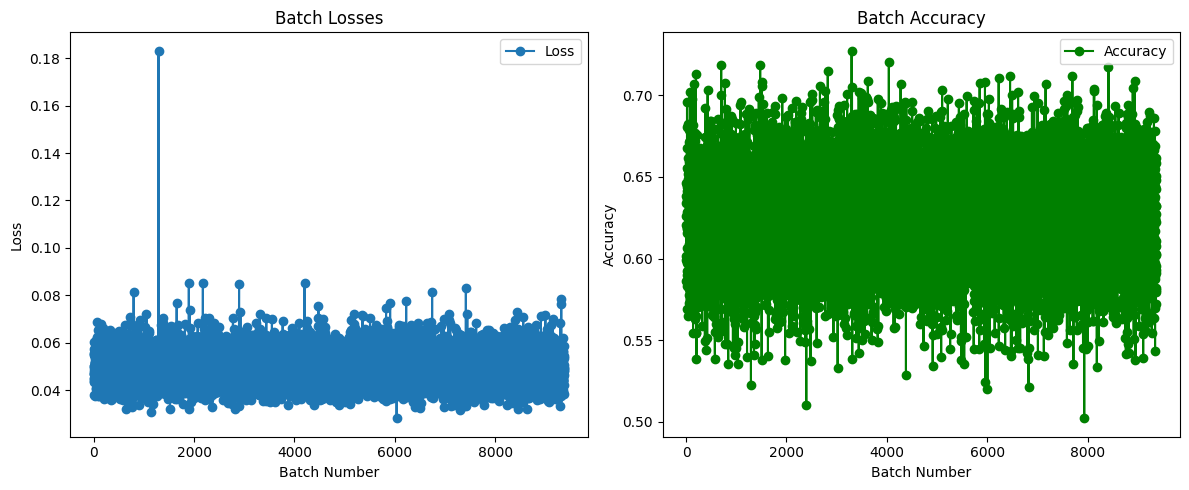

In [60]:
avg_loss, avg_accuracy = evaluate(model, data_loader, criterion, device, pad_token_id)